In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
class NewMnist(object):
    def __init__(self, canvas_size=128):
        self.canvas_size = canvas_size

    def __call__(self, img):
        c, h, w = img.shape
        canvas = torch.zeros((c, self.canvas_size, self.canvas_size), dtype=img.dtype)
        
        y_max = self.canvas_size - h
        x_max = self.canvas_size - w
        
        y = random.randint(0, y_max)
        x = random.randint(0, x_max)
        
        canvas[:, y:y+h, x:x+w] = img
        return canvas

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    NewMnist(canvas_size=128), 
    transforms.Normalize((0.5,), (0.5,)) 
])

In [6]:
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [7]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [8]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

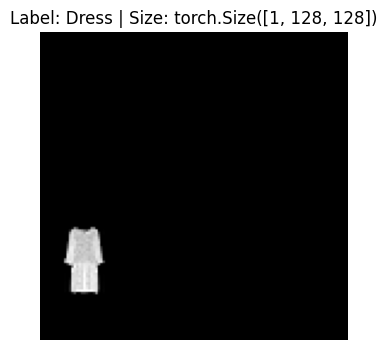

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.figure(figsize=(4,4))
plt.imshow(images[0][0], cmap='gray')
plt.title(f"Label: {classes[labels[0]]} | Size: {images[0].shape}")
plt.axis('off')
plt.show()

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(64, 10)

    def forward(self, x):
        x = self.features(x)      
        x = self.avgpool(x)       
        x = torch.flatten(x, 1)   
        x = self.classifier(x)    
        return x

In [11]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 15
train_losses, test_losses = [], []

In [21]:
from sklearn.metrics import f1_score

In [23]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Acc: {100 * correct / total:.2f}%")

Epoch [1/15], Train Loss: 0.3081, Test Loss: 0.3402, Acc: 87.44%
Epoch [2/15], Train Loss: 0.3002, Test Loss: 0.3196, Acc: 88.33%
Epoch [3/15], Train Loss: 0.2954, Test Loss: 0.2997, Acc: 89.24%
Epoch [4/15], Train Loss: 0.2886, Test Loss: 0.3007, Acc: 89.41%
Epoch [5/15], Train Loss: 0.2818, Test Loss: 0.3112, Acc: 89.02%
Epoch [6/15], Train Loss: 0.2789, Test Loss: 0.3006, Acc: 88.88%
Epoch [7/15], Train Loss: 0.2726, Test Loss: 0.2833, Acc: 89.97%
Epoch [8/15], Train Loss: 0.2730, Test Loss: 0.2957, Acc: 89.45%
Epoch [9/15], Train Loss: 0.2633, Test Loss: 0.2995, Acc: 89.23%
Epoch [10/15], Train Loss: 0.2584, Test Loss: 0.2961, Acc: 89.51%
Epoch [11/15], Train Loss: 0.2538, Test Loss: 0.2786, Acc: 89.97%
Epoch [12/15], Train Loss: 0.2512, Test Loss: 0.2784, Acc: 89.85%
Epoch [13/15], Train Loss: 0.2463, Test Loss: 0.2729, Acc: 90.02%
Epoch [14/15], Train Loss: 0.2443, Test Loss: 0.2759, Acc: 89.88%
Epoch [15/15], Train Loss: 0.2410, Test Loss: 0.2956, Acc: 88.91%


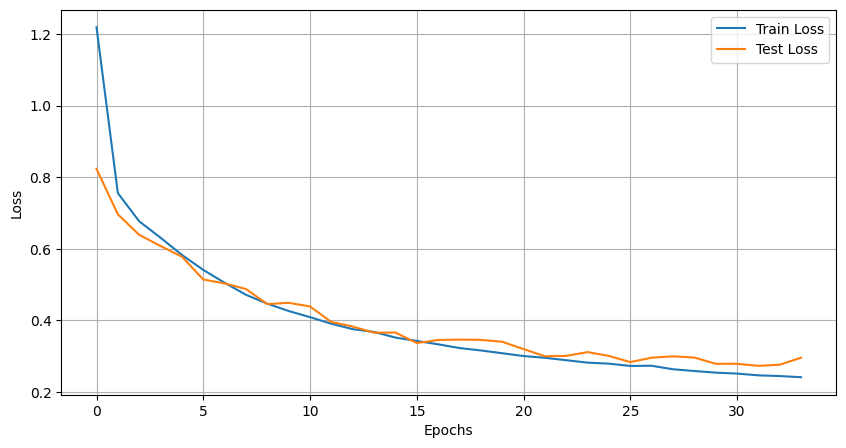

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle


def plot_roc_auc(model, loader, n_classes=10):
    model.eval()
    
    y_test = []
    y_score = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            
            y_test.extend(labels.cpu().numpy())
            y_score.extend(probs.cpu().numpy())

    y_test = np.array(y_test)
    y_score = np.array(y_score)
    
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 8))
    
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2) 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC AUC')
    plt.legend(loc="lower right")
    plt.show()

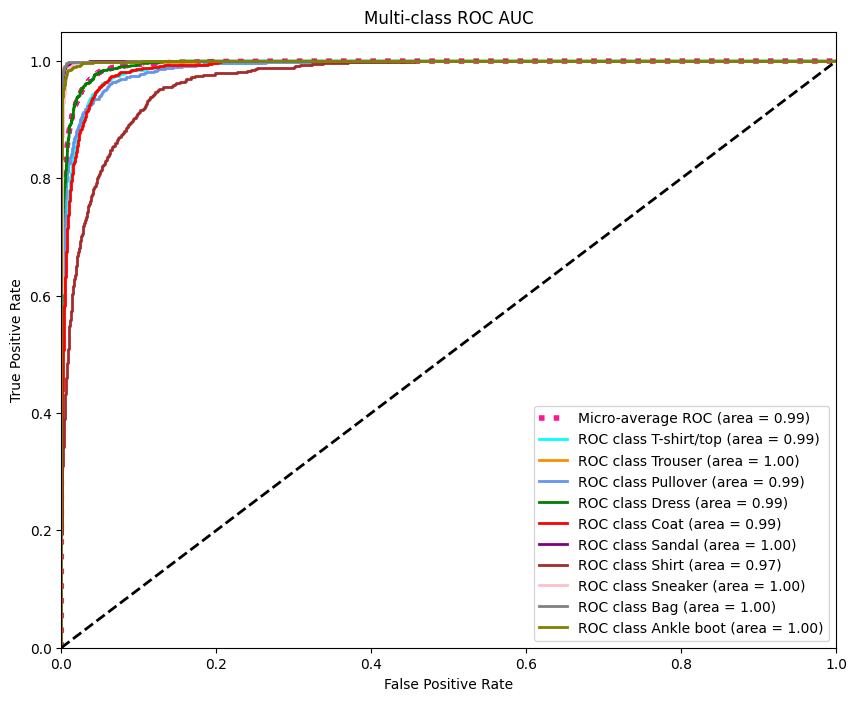

In [26]:
plot_roc_auc(model, test_loader)

Epoch [15/15]
F1-Weighted: 0.8915 | F1-Macro: 0.8915


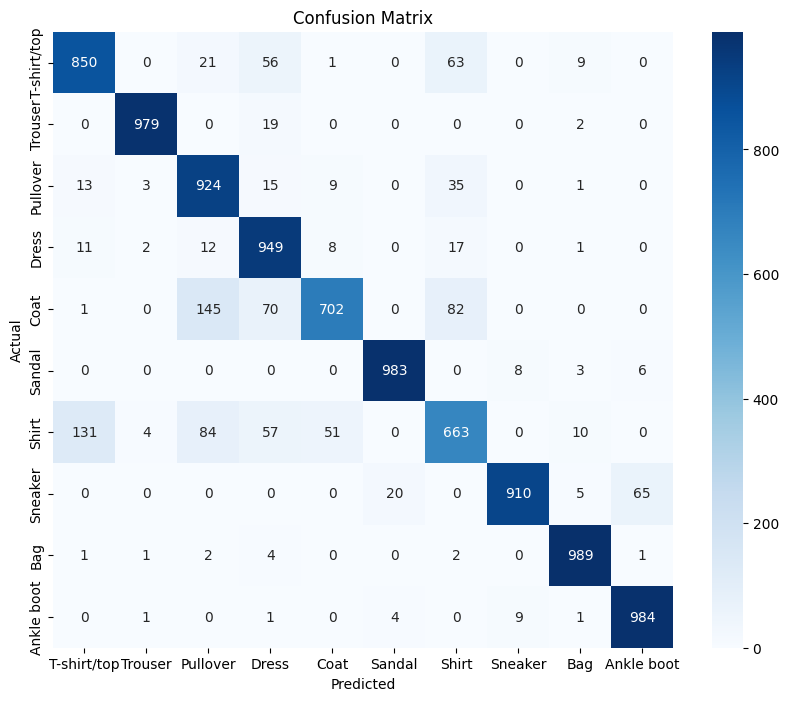

In [27]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
f1 = f1_score(all_labels, all_preds, average='weighted')

f1_mac = f1_score(all_labels, all_preds, average='macro')

print(f"Epoch [{epoch+1}/{epochs}]")
print(f"F1-Weighted: {f1:.4f} | F1-Macro: {f1_mac:.4f}")


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

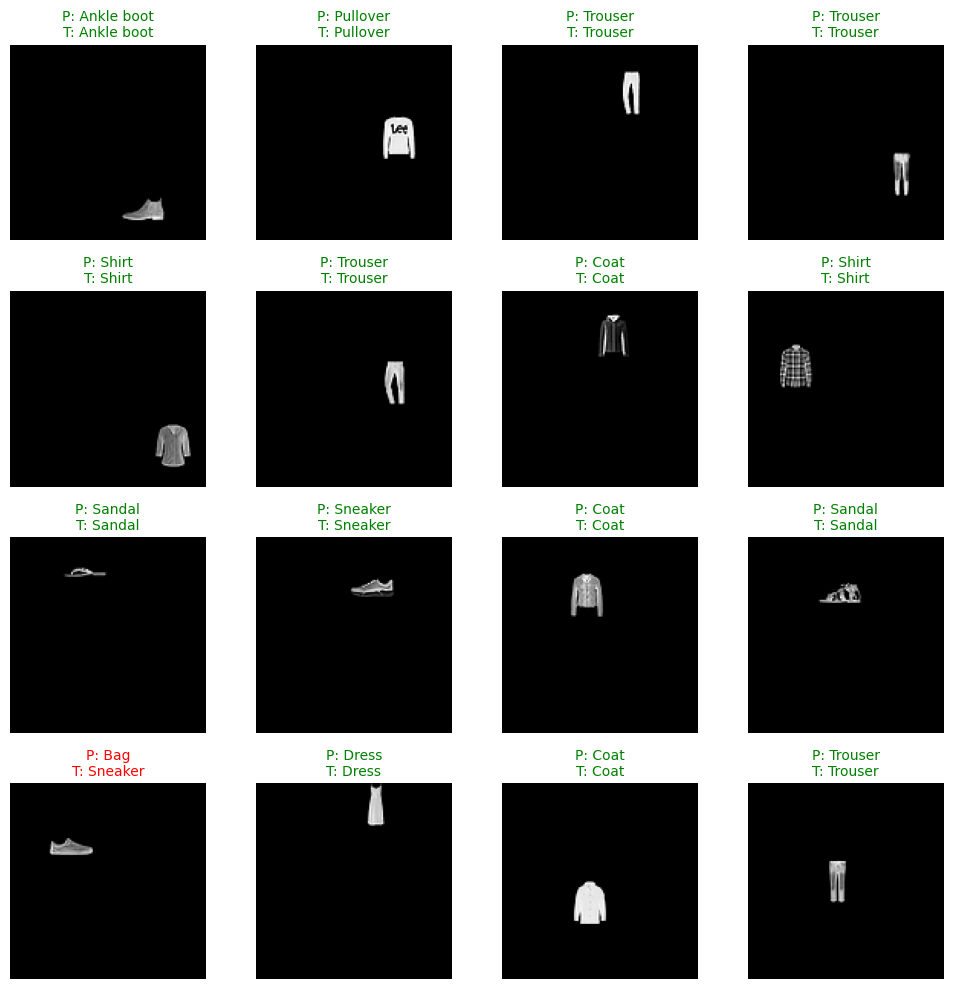

In [28]:
inputs, labels = next(iter(test_loader))
inputs = inputs[:16].to(device)
labels = labels[:16]
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = inputs[i].cpu().squeeze()
    ax.imshow(img, cmap='gray')
    color = 'green' if preds[i] == labels[i] else 'red'
    ax.set_title(f"P: {classes[preds[i]]}\nT: {classes[labels[i]]}", color=color, fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [29]:
from PIL import Image

def visualize_activation(model, img_tensor, true_label):
    model.eval()
    with torch.no_grad():
        features = model.features(img_tensor)
        output = model(img_tensor)
        pred_idx = output.argmax(dim=1).item()
        class_weights = model.classifier.weight[pred_idx]
        cam = torch.zeros(features.shape[2:], dtype=torch.float32).to(device)
        for i, w in enumerate(class_weights):
            cam += w * features[0, i, :, :]
        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam)
        cam = cam.cpu().numpy()
        cam_img = Image.fromarray(np.uint8(255 * cam))
        cam_img = cam_img.resize((128, 128), Image.BILINEAR)
        heatmap = np.array(cam_img)

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img_tensor.cpu().squeeze(), cmap='gray')
        plt.title(f"True: {classes[true_label]}\nPred: {classes[pred_idx]}")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(img_tensor.cpu().squeeze(), cmap='gray')
        plt.imshow(heatmap, cmap='jet', alpha=0.5) 
        plt.axis('off')
        plt.show()

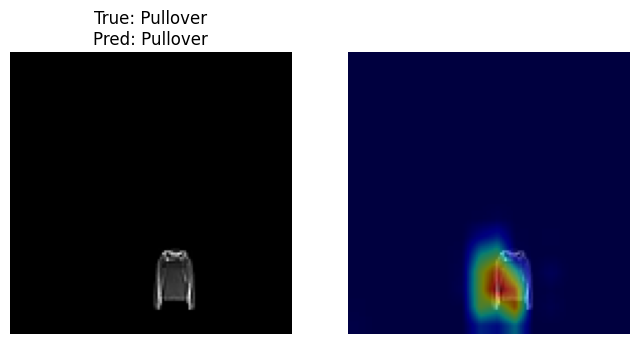

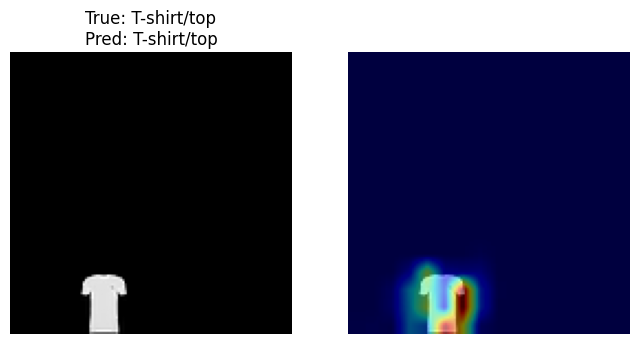

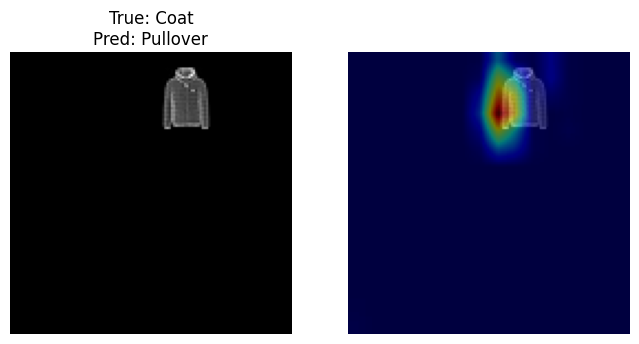

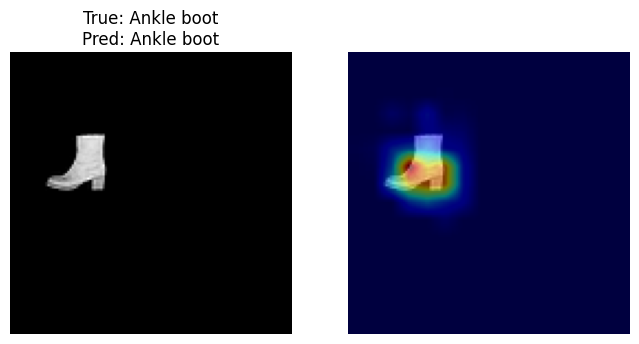

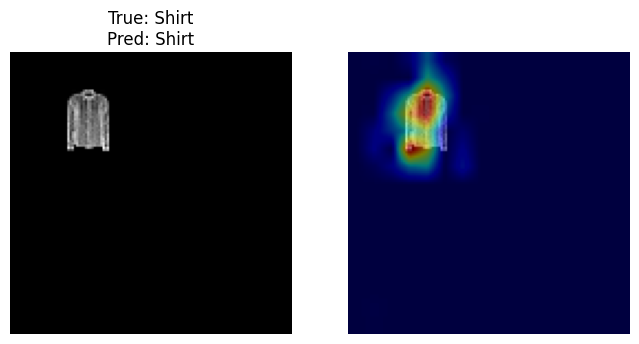

In [30]:
for _ in range(5):
    rand_idx = random.randint(0, len(test_set)-1)
    img, label = test_set[rand_idx]
    img = img.unsqueeze(0).to(device)
    visualize_activation(model, img, label)